# Extracting insights from structured data with Text to SQL
In this notebook we will explore another important modality of data, structured data, and how we can leverage it to extract insights from it. We will prompt the LLM to translate a user's question into a SQL query that runs against a database. Text to SQL is a task where the goal is to convert a natural language question into a SQL query that can be executed on a database to retrieve the answer. This task is particularly useful in the context of databases, where users can ask questions in natural language and get the answers in a structured format.


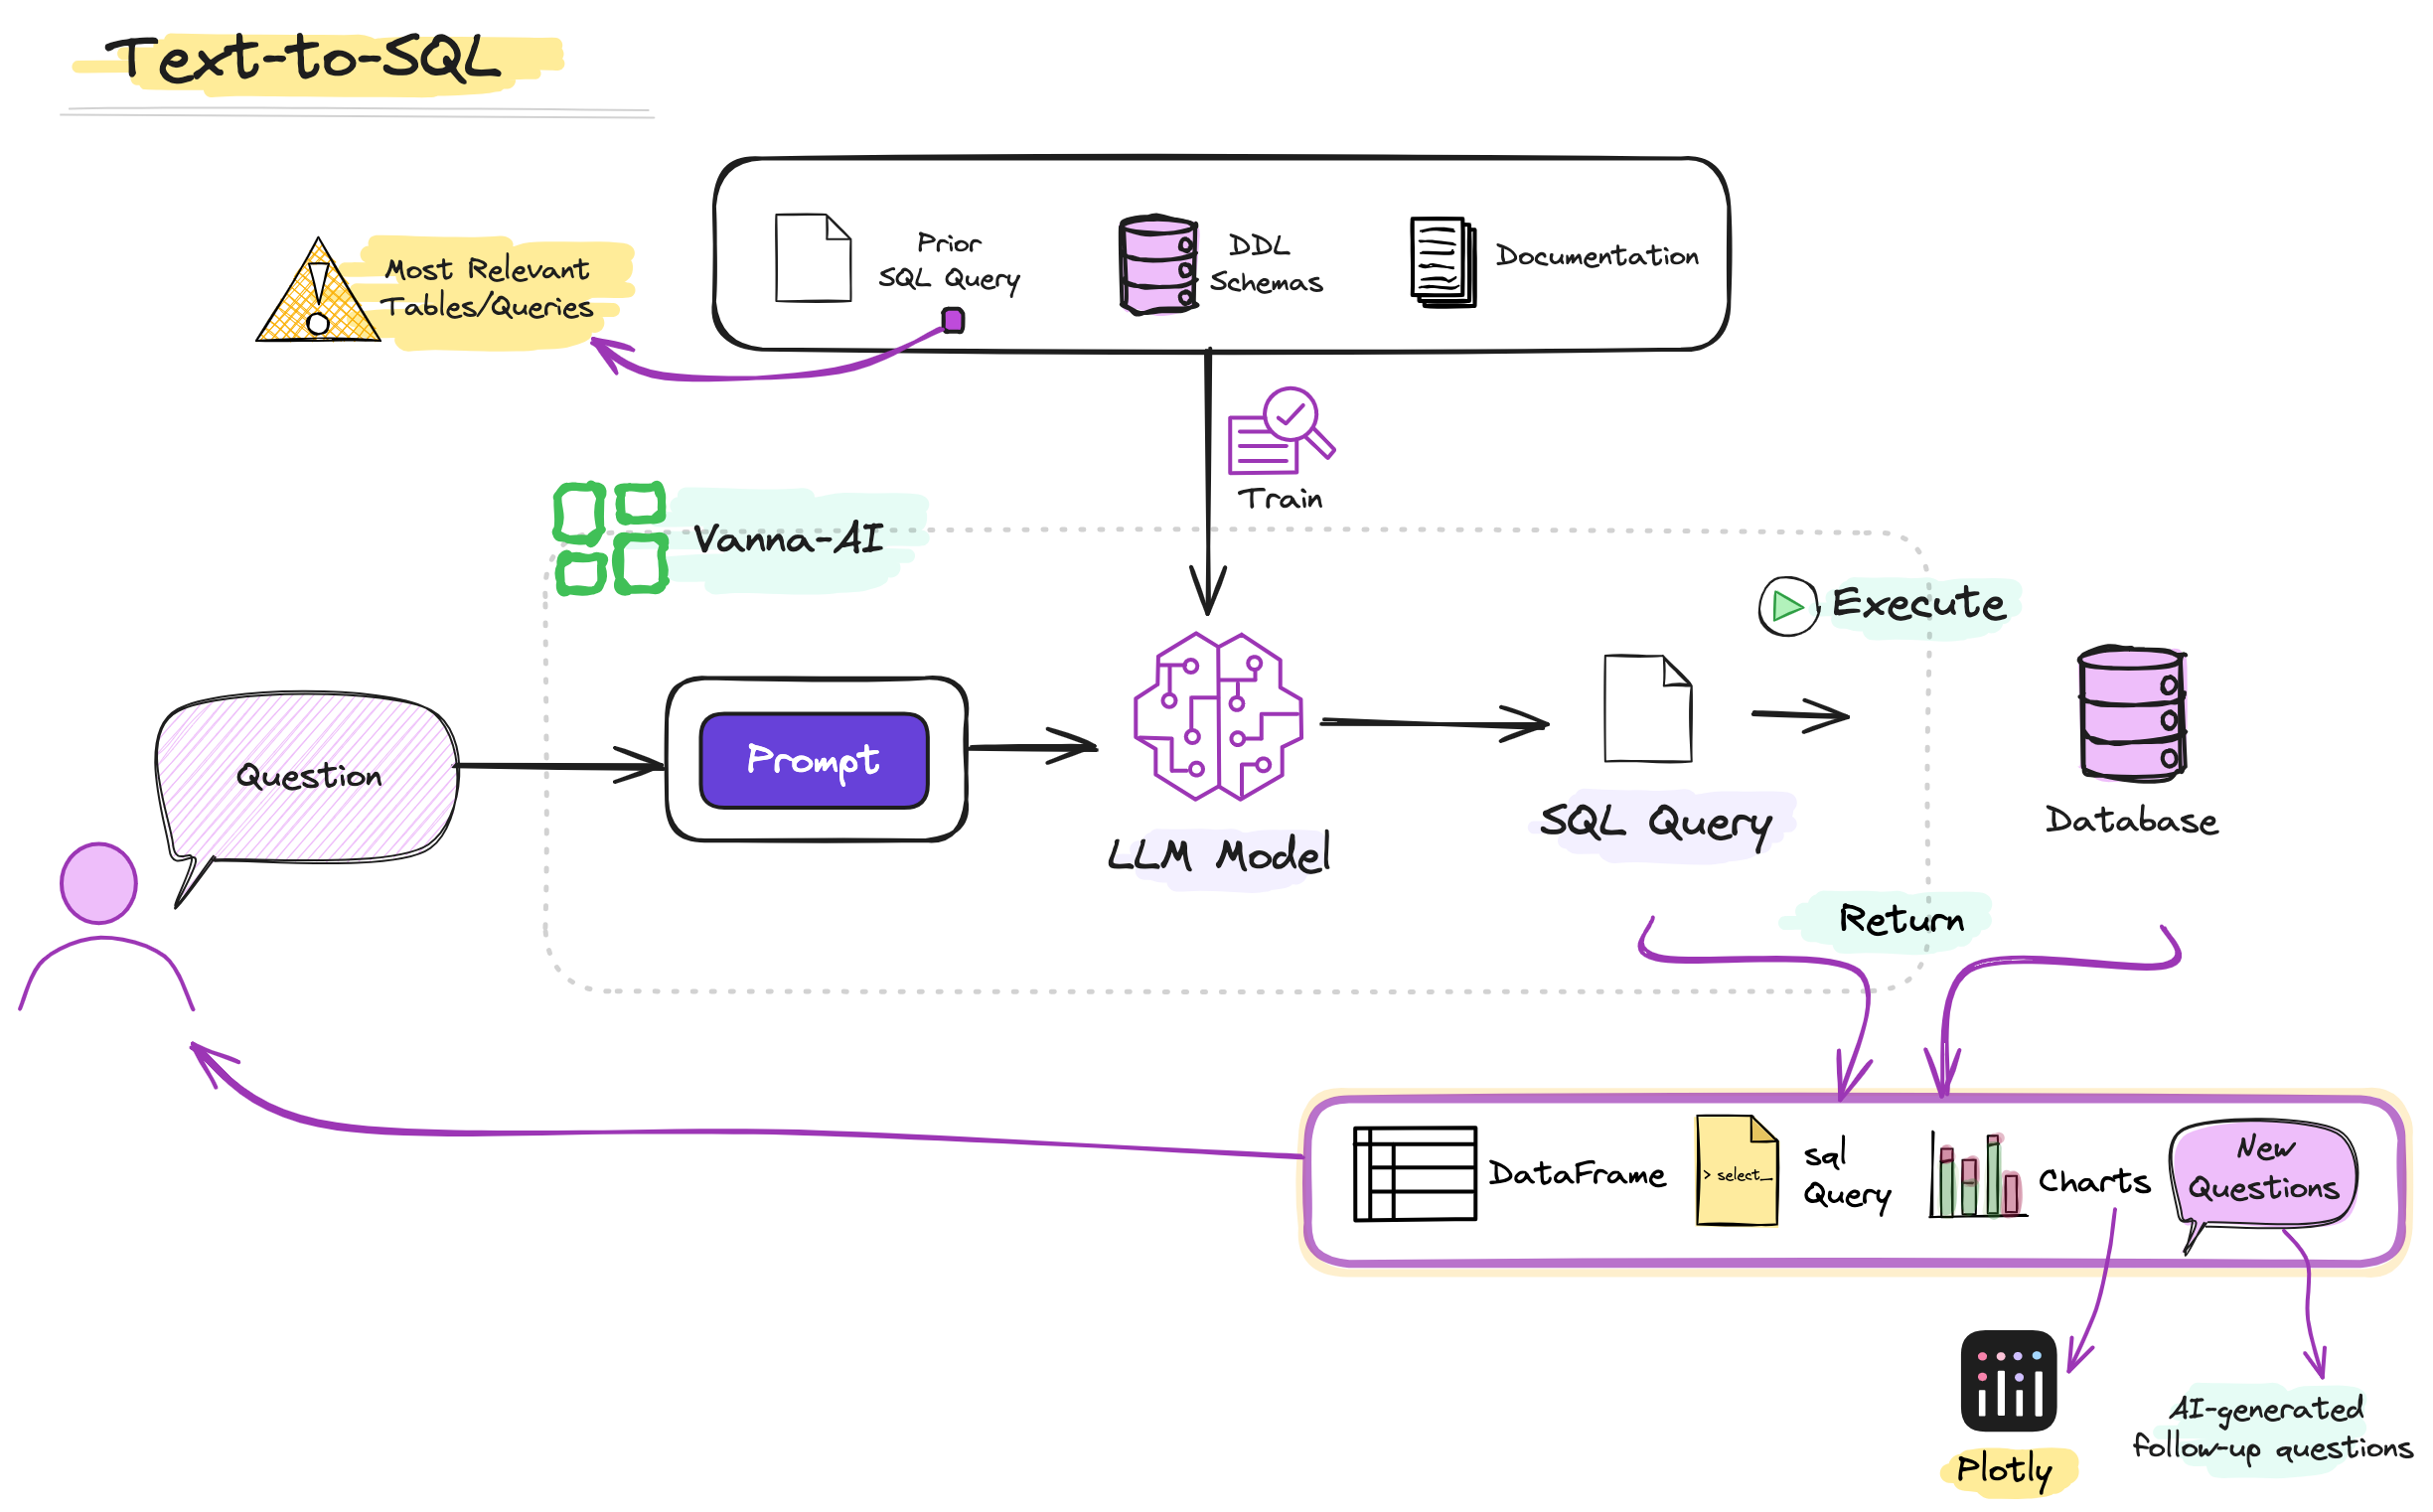

In [1]:
import sys
import os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))
from utils.environment_validation import validate_environment, validate_model_access
validate_environment("sql_rag_requirements.txt")

Validating base environment
Base environment validated successfully


Validating lab environment from requirements.txt ✨

ENVIRONMENT STATUS
✅  scikit-learn is installed
✅  boto3>=1.34.144 is installed
❌ duckdb is not installed
❌ duckdb-engine is not installed
❌ vanna is not installed

Installing missing libraries

duckdb has been installed successfully.
duckdb-engine has been installed successfully.
vanna[chromadb,duckdb] has been installed successfully.


All required libraries are installed.🎉
You may proceed with the lab! 🚀

In [2]:
required_models = [
    "anthropic.claude-3-sonnet-20240229-v1:0",
    "anthropic.claude-3-haiku-20240307-v1:0",
]
validate_model_access(required_models)

MODEL ACCESS STATUS
✅  anthropic.claude-3-sonnet-20240229-v1:0 is accessible
✅  anthropic.claude-3-haiku-20240307-v1:0 is accessible

All required models are accessible.🎉
You may proceed with the lab! 🚀

In [3]:
# delete any prior artifacts
!rm -f chroma.sqlite3 credit_scoring.duckdb 

## Data Ingestion
The first step is to obtain the dataset and load it into a database for querying. We'll download an [OpenML credit loans](https://www.openml.org/search?type=data&status=active&id=45938&sort=runs) and then load it into a [DuckDB database](https://duckdb.org/). 

In [4]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [5]:
data = fetch_openml(data_id=45938)["data"]

In [6]:
# preview the dataset
data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162
2,0x1604,CUS_0xd40,March,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231


The dataset comes as a single table which contains the customer, accounts, and monthly payment information. To make this more realistic, we will break the dataset into 3 tables one for each entity (customer, account, and monthly payment) and then create a foreign key relationship between them.

In [7]:
def extract_customers(df):
    customers = (
        df[["Customer_ID", "Name", "Age", "SSN", "Occupation", "Annual_Income"]]
        .drop_duplicates("Customer_ID")
        .reset_index(drop=True)
    )
    return customers


def extract_accounts(df):
    accounts = (
        df[
            [
                "Customer_ID",
                "Num_Bank_Accounts",
                "Num_Credit_Card",
                "Num_of_Loan",
                "Type_of_Loan",
            ]
        ]
        .drop_duplicates("Customer_ID")
        .reset_index(drop=True)
    )
    return accounts


def extract_monthly_records(df):
    monthly_records = df[
        [
            "ID",
            "Customer_ID",
            "Month",
            "Monthly_Inhand_Salary",
            "Delay_from_due_date",
            "Num_of_Delayed_Payment",
            "Changed_Credit_Limit",
            "Num_Credit_Inquiries",
            "Credit_Mix",
            "Outstanding_Debt",
            "Credit_Utilization_Ratio",
            "Credit_History_Age",
            "Payment_of_Min_Amount",
            "Total_EMI_per_month",
            "Amount_invested_monthly",
            "Payment_Behaviour",
            "Monthly_Balance",
        ]
    ]
    return monthly_records


customers_table = extract_customers(data)
accounts_table = extract_accounts(data)
monthly_records_table = extract_monthly_records(data)

Now that we have the dataset split into 3 tables, we can create a database and load the data into it. We will use DuckDB, a lightweight in-memory database that is easy to use and has good support for SQL queries.

We do this by running DDL commands and ingesting the pandas dataframes into the database.

In [8]:
import duckdb


# Create or connect to a DuckDB database
conn = duckdb.connect("credit_scoring.duckdb")

# Create tables and insert data into DuckDB

# Customers Table
customers_ddl = "CREATE TABLE IF NOT EXISTS customers (Customer_ID VARCHAR, Name VARCHAR, Age INTEGER, SSN VARCHAR, Occupation VARCHAR, Annual_Income FLOAT)"
conn.execute(customers_ddl)
conn.register("customers_df", customers_table)
conn.execute("INSERT INTO customers SELECT * FROM customers_df")

# Accounts Table
accounts_ddl = "CREATE TABLE IF NOT EXISTS accounts (Customer_ID VARCHAR, Num_Bank_Accounts INTEGER, Num_Credit_Card INTEGER, Num_of_Loan INTEGER, Type_of_Loan VARCHAR)"
conn.execute(accounts_ddl)
conn.register("accounts_df", accounts_table)
conn.execute("INSERT INTO accounts SELECT * FROM accounts_df")

# Monthly Records Table
records_ddl = "CREATE TABLE IF NOT EXISTS monthly_records (ID VARCHAR, Customer_ID VARCHAR, Month VARCHAR, Monthly_Inhand_Salary FLOAT, Delay_from_due_date INTEGER, Num_of_Delayed_Payment INTEGER, Changed_Credit_Limit FLOAT, Num_Credit_Inquiries INTEGER, Credit_Mix VARCHAR, Outstanding_Debt FLOAT, Credit_Utilization_Ratio FLOAT, Credit_History_Age VARCHAR, Payment_of_Min_Amount VARCHAR, Total_EMI_per_month FLOAT, Amount_invested_monthly FLOAT, Payment_Behaviour VARCHAR, Monthly_Balance FLOAT)"
conn.execute(records_ddl)
conn.register("monthly_records_df", monthly_records_table)
conn.execute("INSERT INTO monthly_records SELECT * FROM monthly_records_df")

# Close the connection
conn.close()

Let's test the connection to the database and run a simple query to check if the data was loaded correctly.

In [9]:
conn = duckdb.connect('credit_scoring.duckdb')
query_result = conn.execute("SELECT * FROM customers WHERE Age > 30").df()
conn.close()

query_result.head()

,Customer_ID,Name,Age,SSN,Occupation,Annual_Income
0,CUS_0x2dbc,Langep,34,486-85-3974,_______,143162.640625
1,CUS_0xb891,Jasond,54,072-31-6145,Entrepreneur,30689.890625
2,CUS_0x95ee,Np,31,612-70-8987,Lawyer,73928.460938
3,CUS_0x284a,Nadiaq,33,411-51-0676,Lawyer,131313.406250
4,CUS_0x5407,Annk,7580,500-92-6408,Media_Manager,34081.378906


## Text to SQL pipeline
The next step is to build our Text to SQL pipeline. One of the easiest ways to do this is to leverage the [Vanna](https://github.com/vanna-ai/vanna) library. This library abstracts many of the patterns and best practices for building a Text to SQL pipeline and allows us to focus on the data and the model.

Behind the scenes, Vanna uses Retrieval Augmented Generation (RAG) to generate the SQL query. It utilizes a vector database to store information about our data such as the schema, table names, and column names, example SQL statements, data documentation, and others. This information is then used to retrieve the most relevant information when generating the SQL query.

Let's see how we can create a custom pipeline that leverages Bedrock and our DuckDB database.

In [10]:
from vanna.chromadb import ChromaDB_VectorStore
from vanna.bedrock.bedrock_converse import Bedrock_Converse
import boto3
import re

Bellow is where we configure our Vanna text to sql pipeline. We'll use Claude 3 models from Bedrock, a local [ChromaDB](https://www.trychroma.com/) vector database that is natively supported by Vanna, and our DuckDB database.

There are a few modifications to get the best results with Claude3 models. First is the default `initial_prompt` is modified to instruct Claude to output the generated sql inot `<sql></sql>` xml tags. Secondly a custom `extract_sql` function is implemented to extract the generated sql from the xml tags.

In [11]:
bedrock_runtime = boto3.client("bedrock-runtime")
config = {
    "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
    "temperature": 0.4,
    "max_tokens": 2048,
    "initial_prompt": f"You are an ANSI SQL expert.\n"
    + "Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions.\n"
    + "Always place the generated SQL into <sql></sql> tags.",
}


class MyVanna(ChromaDB_VectorStore, Bedrock_Converse):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Bedrock_Converse.__init__(self, client=bedrock_runtime, config=config)

    def extract_sql(self, llm_response: str) -> str:
        sql_text = re.search(r"<sql>(.*?)</sql>", llm_response, re.DOTALL)
        if sql_text:
            return sql_text.group(1)
        else:
            return llm_response


vn = MyVanna(config)

In [12]:
# connect to the DuckDB database
vn.connect_to_duckdb(url='duckdb:///credit_scoring.duckdb')

False


### "Training" the RAG model
We can now begin to "train" the model by ingesting information into the ChromaDB vector database. First, Vanna can generate some basic documentation for the tables in the database using a built-in template. 

In [13]:
df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS")

# This will break up the information schema into bite-sized chunks that can be referenced by the LLM
plan = vn.get_training_plan_generic(df_information_schema)
plan

Train on Information Schema: credit_scoring.main accounts
Train on Information Schema: credit_scoring.main customers
Train on Information Schema: credit_scoring.main monthly_records

In [14]:
# train on the plan
vn.train(plan=plan)

In [15]:
# Let's see what the generated documentation looks like
training_data = vn.get_training_data()
print(training_data.query("training_data_type == 'documentation'").iloc[0]["content"])

The following columns are in the customers table in the credit_scoring database:

|    | table_catalog   | table_schema   | table_name   | column_name   | data_type   | COLUMN_COMMENT   |
|---:|:----------------|:---------------|:-------------|:--------------|:------------|:-----------------|
|  5 | credit_scoring  | main           | customers    | Customer_ID   | VARCHAR     |                  |
|  6 | credit_scoring  | main           | customers    | Name          | VARCHAR     |                  |
|  7 | credit_scoring  | main           | customers    | Age           | INTEGER     |                  |
|  8 | credit_scoring  | main           | customers    | SSN           | VARCHAR     |                  |
|  9 | credit_scoring  | main           | customers    | Occupation    | VARCHAR     |                  |
| 10 | credit_scoring  | main           | customers    | Annual_Income | FLOAT       |                  |


In [16]:
training_data

,id,question,content,training_data_type
0,4b95dde7-b023-5e4f-b08f-1ee41d1d4ae1-doc,None,The following columns are in the customers tab...,documentation
1,6f70c71b-c4f7-5160-826b-c12c576f0e28-doc,None,The following columns are in the accounts tabl...,documentation
2,9c59a30a-a8fb-5219-88d5-258e69691fa0-doc,None,The following columns are in the monthly_recor...,documentation


Let's add a few more examples of training data using the DDL statements from earlier

In [17]:
vn.train(ddl=customers_ddl)
vn.train(ddl=accounts_ddl)
vn.train(ddl=records_ddl)

Adding ddl: CREATE TABLE IF NOT EXISTS customers (Customer_ID VARCHAR, Name VARCHAR, Age INTEGER, SSN VARCHAR, Occupation VARCHAR, Annual_Income FLOAT)
Adding ddl: CREATE TABLE IF NOT EXISTS accounts (Customer_ID VARCHAR, Num_Bank_Accounts INTEGER, Num_Credit_Card INTEGER, Num_of_Loan INTEGER, Type_of_Loan VARCHAR)
Adding ddl: CREATE TABLE IF NOT EXISTS monthly_records (ID VARCHAR, Customer_ID VARCHAR, Month VARCHAR, Monthly_Inhand_Salary FLOAT, Delay_from_due_date INTEGER, Num_of_Delayed_Payment INTEGER, Changed_Credit_Limit FLOAT, Num_Credit_Inquiries INTEGER, Credit_Mix VARCHAR, Outstanding_Debt FLOAT, Credit_Utilization_Ratio FLOAT, Credit_History_Age VARCHAR, Payment_of_Min_Amount VARCHAR, Total_EMI_per_month FLOAT, Amount_invested_monthly FLOAT, Payment_Behaviour VARCHAR, Monthly_Balance FLOAT)


'd4aded77-8e96-5bc1-8313-5bd98b6c5578-ddl'

We can add additional documentation as well. For example, the only thing the LLM would know about the `Month` field is that it is a `VARCHAR`, but the month could be represented in any number of ways for example `January`, `Jan`, `01`, `01/24`, etc. We can add this information to the vector database to help the LLM generate the correct SQL query when it needs to filter by month.

In [18]:
vn.train(documentation="In the records table, the column Month has the following values: January, February, March, April, May, June, July, August")

Adding documentation....


'b0e5b997-6557-5732-b2f9-2173a5d70bb1-doc'

In [19]:
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,376ae67a-43de-562f-8b3e-62037c44e029-ddl,None,CREATE TABLE IF NOT EXISTS customers (Customer...,ddl
1,d4aded77-8e96-5bc1-8313-5bd98b6c5578-ddl,None,CREATE TABLE IF NOT EXISTS monthly_records (ID...,ddl
2,d8d5bdb1-64ea-5b59-afe6-6fcebc3a439b-ddl,None,CREATE TABLE IF NOT EXISTS accounts (Customer_...,ddl
0,4b95dde7-b023-5e4f-b08f-1ee41d1d4ae1-doc,None,The following columns are in the customers tab...,documentation
1,6f70c71b-c4f7-5160-826b-c12c576f0e28-doc,None,The following columns are in the accounts tabl...,documentation
2,9c59a30a-a8fb-5219-88d5-258e69691fa0-doc,None,The following columns are in the monthly_recor...,documentation
3,b0e5b997-6557-5732-b2f9-2173a5d70bb1-doc,None,"In the records table, the column Month has the...",documentation


### Query the database with natural language

In [20]:
# Let's start with a simple question
sql, result, _ = vn.ask(question="What is the average age of the customers?", visualize=False)
result

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


SQL Prompt: [{'role': 'system', 'content': "You are an ANSI SQL expert.\nPlease help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions.\nAlways place the generated SQL into <sql></sql> tags.\n===Tables \nCREATE TABLE IF NOT EXISTS customers (Customer_ID VARCHAR, Name VARCHAR, Age INTEGER, SSN VARCHAR, Occupation VARCHAR, Annual_Income FLOAT)\n\nCREATE TABLE IF NOT EXISTS accounts (Customer_ID VARCHAR, Num_Bank_Accounts INTEGER, Num_Credit_Card INTEGER, Num_of_Loan INTEGER, Type_of_Loan VARCHAR)\n\nCREATE TABLE IF NOT EXISTS monthly_records (ID VARCHAR, Customer_ID VARCHAR, Month VARCHAR, Monthly_Inhand_Salary FLOAT, Delay_from_due_date INTEGER, Num_of_Delayed_Payment INTEGER, Changed_Credit_Limit FLOAT, Num_Credit_Inquiries INTEGER, Credit_Mix VARCHAR, Outstanding_Debt FLOAT, Credit_Utilization_Ratio FLOAT, Credit_History_Age VARCHAR, Payment_of_Min_Amount VARCHAR, Total_EMI

,average_age
0,122.57128


In [21]:
# Average age seems high, let's find out why
sql, result, _ = vn.ask(question="Who are the top 5 oldest customers?", visualize=False)
result

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


SQL Prompt: [{'role': 'system', 'content': "You are an ANSI SQL expert.\nPlease help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions.\nAlways place the generated SQL into <sql></sql> tags.\n===Tables \nCREATE TABLE IF NOT EXISTS customers (Customer_ID VARCHAR, Name VARCHAR, Age INTEGER, SSN VARCHAR, Occupation VARCHAR, Annual_Income FLOAT)\n\nCREATE TABLE IF NOT EXISTS accounts (Customer_ID VARCHAR, Num_Bank_Accounts INTEGER, Num_Credit_Card INTEGER, Num_of_Loan INTEGER, Type_of_Loan VARCHAR)\n\nCREATE TABLE IF NOT EXISTS monthly_records (ID VARCHAR, Customer_ID VARCHAR, Month VARCHAR, Monthly_Inhand_Salary FLOAT, Delay_from_due_date INTEGER, Num_of_Delayed_Payment INTEGER, Changed_Credit_Limit FLOAT, Num_Credit_Inquiries INTEGER, Credit_Mix VARCHAR, Outstanding_Debt FLOAT, Credit_Utilization_Ratio FLOAT, Credit_History_Age VARCHAR, Payment_of_Min_Amount VARCHAR, Total_EMI

,Name,Age
0,Tim McLaughlinz,8592
1,Sarah N.y,8587
2,None,8490
3,Scuffhamf,8481
4,Mihir Dalald,8425


In [22]:
# Let's try another question
sql, result, _ = vn.ask(question="Which customer makes the largest average monthly payment?", visualize=False)
result 

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


SQL Prompt: [{'role': 'system', 'content': "You are an ANSI SQL expert.\nPlease help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions.\nAlways place the generated SQL into <sql></sql> tags.\n===Tables \nCREATE TABLE IF NOT EXISTS monthly_records (ID VARCHAR, Customer_ID VARCHAR, Month VARCHAR, Monthly_Inhand_Salary FLOAT, Delay_from_due_date INTEGER, Num_of_Delayed_Payment INTEGER, Changed_Credit_Limit FLOAT, Num_Credit_Inquiries INTEGER, Credit_Mix VARCHAR, Outstanding_Debt FLOAT, Credit_Utilization_Ratio FLOAT, Credit_History_Age VARCHAR, Payment_of_Min_Amount VARCHAR, Total_EMI_per_month FLOAT, Amount_invested_monthly FLOAT, Payment_Behaviour VARCHAR, Monthly_Balance FLOAT)\n\nCREATE TABLE IF NOT EXISTS customers (Customer_ID VARCHAR, Name VARCHAR, Age INTEGER, SSN VARCHAR, Occupation VARCHAR, Annual_Income FLOAT)\n\nCREATE TABLE IF NOT EXISTS accounts (Customer_ID VARCH

,Name,avg_monthly_payment
0,Bhaswatit,29986.742104


In [23]:
# This question would have failed if we did not provide the additional documentation about the values in the Month column
sql, result, _ = vn.ask(question="Which customer had the largest increase in monthly salary from 01 to 08? ", visualize=False, print_results=True)
result

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


SQL Prompt: [{'role': 'system', 'content': "You are an ANSI SQL expert.\nPlease help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions.\nAlways place the generated SQL into <sql></sql> tags.\n===Tables \nCREATE TABLE IF NOT EXISTS monthly_records (ID VARCHAR, Customer_ID VARCHAR, Month VARCHAR, Monthly_Inhand_Salary FLOAT, Delay_from_due_date INTEGER, Num_of_Delayed_Payment INTEGER, Changed_Credit_Limit FLOAT, Num_Credit_Inquiries INTEGER, Credit_Mix VARCHAR, Outstanding_Debt FLOAT, Credit_Utilization_Ratio FLOAT, Credit_History_Age VARCHAR, Payment_of_Min_Amount VARCHAR, Total_EMI_per_month FLOAT, Amount_invested_monthly FLOAT, Payment_Behaviour VARCHAR, Monthly_Balance FLOAT)\n\nCREATE TABLE IF NOT EXISTS customers (Customer_ID VARCHAR, Name VARCHAR, Age INTEGER, SSN VARCHAR, Occupation VARCHAR, Annual_Income FLOAT)\n\nCREATE TABLE IF NOT EXISTS accounts (Customer_ID VARCH

,Name,salary_increase
0,Gerryv,12824.834961


In [24]:
# let's try a more complex query
sql, result, _ = vn.ask(question="Create a binning of annual salary and analyze that against the average number of credit cards ", visualize=False, print_results=True)
result

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


SQL Prompt: [{'role': 'system', 'content': "You are an ANSI SQL expert.\nPlease help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions.\nAlways place the generated SQL into <sql></sql> tags.\n===Tables \nCREATE TABLE IF NOT EXISTS monthly_records (ID VARCHAR, Customer_ID VARCHAR, Month VARCHAR, Monthly_Inhand_Salary FLOAT, Delay_from_due_date INTEGER, Num_of_Delayed_Payment INTEGER, Changed_Credit_Limit FLOAT, Num_Credit_Inquiries INTEGER, Credit_Mix VARCHAR, Outstanding_Debt FLOAT, Credit_Utilization_Ratio FLOAT, Credit_History_Age VARCHAR, Payment_of_Min_Amount VARCHAR, Total_EMI_per_month FLOAT, Amount_invested_monthly FLOAT, Payment_Behaviour VARCHAR, Monthly_Balance FLOAT)\n\nCREATE TABLE IF NOT EXISTS customers (Customer_ID VARCHAR, Name VARCHAR, Age INTEGER, SSN VARCHAR, Occupation VARCHAR, Annual_Income FLOAT)\n\nCREATE TABLE IF NOT EXISTS accounts (Customer_ID VARCH

,income_bin,avg_num_credit_cards
0,Low Income,23.464353
1,High Income,21.503432
2,Medium Income,19.366761


## Conclusion
In this notebook, we have seen how to extract insights from structured data using Text to SQL. We have loaded a dataset into a database, created a Text to SQL pipeline using Vanna, and queried the database using natural language. This is a powerful tool that can be used to extract insights from structured data in a more intuitive way.